***Problem Statement-***

Determining if an opponent is going to run or pass is a difficult thing in the NFL.  Teams that have top tier RB's may run the ball more often, and teams with the best QB's in the league, may opt to throw the ball at a higher frequency.  We're looking to determine if we can find any patterns in the data that can suggest if a team is more likely to run the ball, or pass the ball in a given situation. 


***Business Problem-***

In order to add value to teams/coaching staffs, we need to be able to determine if a play is a pass or a run more efficiently than just guessing.  In order to do this, we need to be correct at a frequency that is higher than that in which teams actually run and pass the ball on a given play for a specific scenario.  To do this, we'll be factoring in quarter, time in quarter, down, distance to go, field position (yard line), formation, and offensive team.  By looking at each of these variables we can see if there are any trends that would help us as the defensive team be able to predict whether or not the offense is more likely to pass the ball, or run it.  With this knowledge, we can more confidently position our defense in order to be more successful, more often.  

Plan to use decision trees and random forests for modeling.

In [1]:
import graphviz
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import tree
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

# Obtain

In [2]:
plays_2020 = pd.read_csv(r"C:\Users\Nick\Desktop\pbp2020.csv")
plays_2019 = pd.read_csv(r"C:\Users\Nick\Desktop\pbp2019.csv")
plays_2018 = pd.read_csv(r"C:\Users\Nick\Desktop\pbp2018.csv")

plays_2020 = plays_2020.set_index(['GameId'])
plays_2019 = plays_2019.set_index(['GameId'])
plays_2018 = plays_2018.set_index(['GameId'])


#### Combine yearly data.

In [3]:
plays = pd.concat([plays_2020,plays_2019,plays_2018]).drop_duplicates().reset_index(drop=True)

In [4]:
plays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132036 entries, 0 to 132035
Data columns (total 44 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   GameDate                        132036 non-null  object 
 1   Quarter                         132036 non-null  int64  
 2   Minute                          132036 non-null  int64  
 3   Second                          132036 non-null  int64  
 4   OffenseTeam                     122890 non-null  object 
 5   DefenseTeam                     129436 non-null  object 
 6   Down                            132036 non-null  int64  
 7   ToGo                            132036 non-null  int64  
 8   YardLine                        132036 non-null  int64  
 9   Unnamed: 10                     0 non-null       float64
 10  SeriesFirstDown                 132036 non-null  int64  
 11  Unnamed: 12                     0 non-null       float64
 12  NextScore       

# Explore

#### Check for duplicates and missing values

In [5]:
# checking for duplicates
plays.index.duplicated().sum()

0

In [6]:
# checking for missing values
plays.isna().sum()

GameDate                               0
Quarter                                0
Minute                                 0
Second                                 0
OffenseTeam                         9146
DefenseTeam                         2600
Down                                   0
ToGo                                   0
YardLine                               0
Unnamed: 10                       132036
SeriesFirstDown                        0
Unnamed: 12                       132036
NextScore                              0
Description                            0
TeamWin                                0
Unnamed: 16                       132036
Unnamed: 17                       132036
SeasonYear                             0
Yards                                  0
Formation                           1708
PlayType                            3790
IsRush                                 0
IsPass                                 0
IsIncomplete                           0
IsTouchdown     

In [7]:
plays.head()

,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,Unnamed: 10,...,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2020-12-26,2,9,44,LV,MIA,2,10,82,NaN,...,0,0,NaN,18,OPP,0,NaN,0,NaN,0
1,2020-12-26,2,9,3,LV,MIA,3,19,73,NaN,...,0,0,LEFT GUARD,27,OPP,0,NaN,0,NaN,0
2,2020-12-25,3,1,17,MIN,NO,3,9,67,NaN,...,0,0,NaN,33,OPP,0,NO,1,DEFENSIVE HOLDING,0
3,2020-12-25,3,1,12,MIN,NO,1,10,82,NaN,...,0,0,NaN,18,OPP,1,NO,1,DEFENSIVE PASS INTERFERENCE,17
4,2020-12-25,3,1,6,MIN,NO,1,1,99,NaN,...,0,0,LEFT GUARD,1,OPP,0,NaN,0,NaN,0


#### Investigate situational data before column removal

In [8]:
plays_yards = plays[['Down','ToGo','IsRush', 'Yards']]

In [9]:
plays_yards.head()

,Down,ToGo,IsRush,Yards
0,2,10,0,-9
1,3,19,1,18
2,3,9,0,0
3,1,10,0,0
4,1,1,1,-3


In [10]:
plays_yards = plays_yards.loc[plays['IsRush'] == 1]

In [11]:
plays_yards_1st = plays_yards.loc[plays['Down'] == 1]
plays_yards_2nd = plays_yards.loc[plays['Down'] == 2]
plays_yards_3rd = plays_yards.loc[plays['Down'] == 3]
plays_yards_4th = plays_yards.loc[plays['Down'] == 4]


In [12]:
### 1st down 21267 plays
### 2nd down 12541 plays
### 3rd down 4111 plays

yards_1st_sum = plays_yards_1st['Yards'].sum()
yards_2nd_sum = plays_yards_2nd['Yards'].sum()
yards_3rd_sum = plays_yards_3rd['Yards'].sum()
yards_4th_sum = plays_yards_4th['Yards'].sum()

print((yards_1st_sum)/len(plays_yards_1st))
print((yards_2nd_sum)/len(plays_yards_2nd))
print((yards_3rd_sum)/len(plays_yards_3rd))
print((yards_4th_sum)/len(plays_yards_4th))

4.655898810363474
4.663025277091141
4.701532473850644
2.948844884488449


In [13]:
plays_yards_3rd_long = plays_yards.loc[(
    (plays['Down'] == 3) & (plays['ToGo'] > 5)
)]

In [14]:
plays_yards_3rd_long_sum = plays_yards_3rd_long['Yards'].sum()
print((plays_yards_3rd_long_sum)/len(plays_yards_3rd_long))

6.82300163132137


Significant increase in average yards on rushing plays for 3rd and longer than 5 yards.  This could be do to 3rd and medium to long being seen traditionally as a passing down, and this can be used to potentially exploit defenses in certain situations.

**Remove columns that are no use to us (don't have predictive qualities- such as penalties which would be after the play)**

In [15]:
#### Removing columns

plays = plays.drop(['GameDate', 
                    'Unnamed: 10', 
                    'Unnamed: 12',  
                    'Unnamed: 16', 
                    'Unnamed: 17', 
                    'SeasonYear',
                    'IsIncomplete',
                    'IsMeasurement',
                    'RushDirection',
                    'PenaltyType',
                    'PenaltyYards',
                    'Yards',
                    'PassType',
                    'Second',
                    'DefenseTeam',
                    'IsChallenge',
                    'IsChallengeReversed',
                    'Challenger',
                    'IsInterception',
                    'IsFumble',
                    'IsPenalty',
                    'IsTwoPointConversionSuccessful',
                    'RushDirection',
                    'YardLineFixed',
                    'IsPenaltyAccepted',
                    'PenaltyTeam',
                    'PenaltyType',
                    'PenaltyYards',
                    'YardLineDirection'
                   ], axis = 1)

Sorting plays in order of occurrence.

In [16]:
plays = plays.sort_values(by=['Quarter', 'Minute', 'Down'], ascending=[True, False, True])

In [17]:
plays.head()

,Quarter,Minute,OffenseTeam,Down,ToGo,YardLine,SeriesFirstDown,NextScore,Description,TeamWin,Formation,PlayType,IsRush,IsPass,IsTouchdown,IsSack,IsTwoPointConversion,IsNoPlay
10505,1,15,SEA,0,0,35,1,0,5-J.MYERS KICKS 65 YARDS FROM SEA 35 TO END ZO...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10530,1,15,KC,0,0,35,1,0,7-H.BUTKER KICKS 65 YARDS FROM KC 35 TO END ZO...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10570,1,15,BUF,0,0,35,0,0,2-T.BASS KICKS 63 YARDS FROM BUF 35 TO NYJ 2. ...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10691,1,15,CAR,0,0,35,1,0,4-J.SLYE KICKS 65 YARDS FROM CAR 35 TO END ZON...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10769,1,15,DET,0,0,35,1,0,3-J.FOX KICKS 65 YARDS FROM DET 35 TO END ZONE...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0


#### Checking rush/pass ratio

In [18]:
# check 'score to beat'
plays['PlayType'].value_counts()

PASS                    54876
RUSH                    36045
KICK OFF                 7838
PUNT                     6406
TIMEOUT                  5398
SACK                     3849
EXTRA POINT              3698
FIELD GOAL               2829
SCRAMBLE                 2480
NO PLAY                  2363
QB KNEEL                 1180
TWO-POINT CONVERSION      383
EXCEPTION                 381
FUMBLES                   273
CLOCK STOP                234
PENALTY                    13
Name: PlayType, dtype: int64

Combine/remove certain play types.

In [19]:
print(plays['IsRush'].value_counts(normalize=True))

0    0.708224
1    0.291776
Name: IsRush, dtype: float64


In [20]:
plays.head()

,Quarter,Minute,OffenseTeam,Down,ToGo,YardLine,SeriesFirstDown,NextScore,Description,TeamWin,Formation,PlayType,IsRush,IsPass,IsTouchdown,IsSack,IsTwoPointConversion,IsNoPlay
10505,1,15,SEA,0,0,35,1,0,5-J.MYERS KICKS 65 YARDS FROM SEA 35 TO END ZO...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10530,1,15,KC,0,0,35,1,0,7-H.BUTKER KICKS 65 YARDS FROM KC 35 TO END ZO...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10570,1,15,BUF,0,0,35,0,0,2-T.BASS KICKS 63 YARDS FROM BUF 35 TO NYJ 2. ...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10691,1,15,CAR,0,0,35,1,0,4-J.SLYE KICKS 65 YARDS FROM CAR 35 TO END ZON...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0
10769,1,15,DET,0,0,35,1,0,3-J.FOX KICKS 65 YARDS FROM DET 35 TO END ZONE...,0,UNDER CENTER,KICK OFF,0,0,0,0,0,0


In [21]:
# combining pass, sack, scramble data
plays.loc[plays.PlayType == 'PASS', 'IsPass'] = 1
plays.loc[plays.PlayType == 'SACK', 'IsPass'] = 1
plays.loc[plays.PlayType == 'SCRAMBLE', 'IsPass'] = 1
plays.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 132036 entries, 10505 to 125459
Data columns (total 18 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quarter               132036 non-null  int64 
 1   Minute                132036 non-null  int64 
 2   OffenseTeam           122890 non-null  object
 3   Down                  132036 non-null  int64 
 4   ToGo                  132036 non-null  int64 
 5   YardLine              132036 non-null  int64 
 6   SeriesFirstDown       132036 non-null  int64 
 7   NextScore             132036 non-null  int64 
 8   Description           132036 non-null  object
 9   TeamWin               132036 non-null  int64 
 10  Formation             130328 non-null  object
 11  PlayType              128246 non-null  object
 12  IsRush                132036 non-null  int64 
 13  IsPass                132036 non-null  int64 
 14  IsTouchdown           132036 non-null  int64 
 15  IsSack       

In [22]:
# columns where PlayType is 'NO PLAY'
index_names = plays[ (plays['IsNoPlay'] == 1)].index
plays.drop(index_names, inplace = True)

# columns where PlayType is 'QB KNEEL'
index_names = plays[ (plays['PlayType'] == 'QB KNEEL')].index
plays.drop(index_names, inplace = True)


# columns where PlayType is 'TIMEOUT'
index_names = plays[ (plays['PlayType'] == 'TIMEOUT')].index
plays.drop(index_names, inplace = True)

# Drop un-needed columns
plays = plays.drop(['IsSack',
                   'IsNoPlay'], axis = 1)

In [23]:
# dropping plays with 0 for both IsRush and IsPass

misc_play_type = plays[(plays['IsRush'] == 0) & (plays['IsPass'] == 0)].index
plays.drop(misc_play_type, inplace = True)

In [24]:
# dropping plays with 1 for both IsRush and IsPass

pass_and_run = plays[(plays['IsRush'] == 1) & (plays['IsPass'] == 1)].index
plays.drop(pass_and_run, inplace = True)

In [25]:
plays['PlayType'].value_counts()

PASS    51850
RUSH    35059
SACK     3627
Name: PlayType, dtype: int64

In [26]:
plays.isna().sum()

Quarter                 0
Minute                  0
OffenseTeam             3
Down                    0
ToGo                    0
YardLine                0
SeriesFirstDown         0
NextScore               0
Description             0
TeamWin                 0
Formation               0
PlayType                0
IsRush                  0
IsPass                  0
IsTouchdown             0
IsTwoPointConversion    0
dtype: int64

In [27]:
plays['Down'].value_counts()

1    40833
2    30161
3    17902
4     1635
0        5
Name: Down, dtype: int64

In [28]:
# Get indexes where name down doesn't have value 1-4 to remove
index_names = plays[(plays['Down'] == 0)].index 
# Delete these row indexes from dataFrame
plays.drop(index_names , inplace=True)

In [29]:
plays['Down'].value_counts()

1    40833
2    30161
3    17902
4     1635
Name: Down, dtype: int64

In [30]:
plays['ToGo'].value_counts()

10    44936
1      5026
5      4488
7      4356
6      4219
8      3917
4      3891
3      3451
9      3373
2      3358
11     1471
15     1448
12     1203
20     1100
13      892
14      750
17      523
16      519
18      458
19      348
21      168
22      135
25      119
23       97
24       76
26       47
30       41
27       35
28       28
29       22
31        7
33        6
35        6
40        4
32        4
34        4
38        2
41        2
36        1
Name: ToGo, dtype: int64

In [31]:
plays['Formation'].value_counts()

SHOTGUN              52222
UNDER CENTER         30643
NO HUDDLE SHOTGUN     6157
NO HUDDLE             1501
WILDCAT                  3
PUNT                     3
FIELD GOAL               2
Name: Formation, dtype: int64

In [32]:
# Drop Formations with insignificant amount of data

# columns where Formation is 'PUNT'
index_names = plays[ (plays['Formation'] == 'PUNT')].index
plays.drop(index_names, inplace = True)

# columns where Formation is 'WILDCAT'
index_names = plays[ (plays['Formation'] == 'WILDCAT')].index
plays.drop(index_names, inplace = True)


# columns where Formation is 'FIELD GOAL'
index_names = plays[ (plays['Formation'] == 'FIELD GOAL')].index
plays.drop(index_names, inplace = True)

In [33]:
plays['Formation'].value_counts()

SHOTGUN              52222
UNDER CENTER         30643
NO HUDDLE SHOTGUN     6157
NO HUDDLE             1501
Name: Formation, dtype: int64

In [34]:
plays['OffenseTeam'].value_counts()

DAL    3016
ATL    2989
PHI    2988
LA     2944
NE     2933
IND    2929
TB     2874
DET    2874
CAR    2870
NO     2863
CHI    2860
SF     2860
MIN    2856
CIN    2855
LAC    2850
CLE    2848
LV     2845
DEN    2823
PIT    2820
SEA    2815
KC     2813
GB     2798
BAL    2785
JAX    2778
ARI    2773
BUF    2760
NYG    2715
MIA    2707
NYJ    2701
WAS    2665
HOU    2660
TEN    2656
Name: OffenseTeam, dtype: int64

In [35]:
print(plays['IsRush'].value_counts(normalize=True))

0    0.612739
1    0.387261
Name: IsRush, dtype: float64


In [36]:
# 38.7% of plays are rushing plays.  
# Our goal is to correctly predict rush plays at a higher frequency.

Sacks are already factored into IsPass so we can drop PlayType from our dataframe.

In [37]:
plays = plays.drop([
           'SeriesFirstDown',
           'NextScore',
           'Description',
           'TeamWin',
           'IsPass',
           'IsTouchdown',
           'PlayType'], axis = 1)

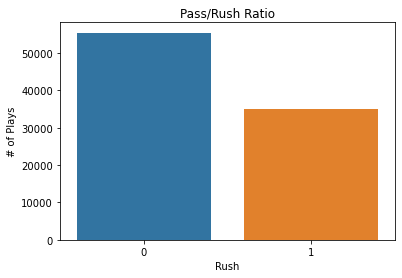

In [38]:
# plot quarters
ax = sns.countplot(x = 'IsRush', data = plays)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.title('Pass/Rush Ratio')
plt.xlabel('Rush')
plt.ylabel('# of Plays')
plt.savefig("PassRushRatio")

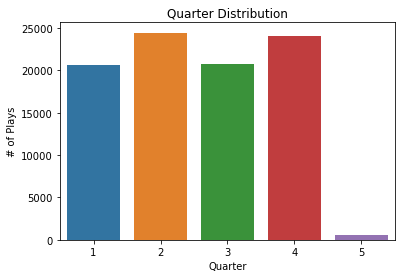

In [39]:
# plot quarters
ax = sns.countplot(x = 'Quarter', data = plays)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.title('Quarter Distribution')
plt.xlabel('Quarter')
plt.ylabel('# of Plays')
plt.savefig("Quarter Dist")

**See that there are more plays in 2nd and 4th quarters (probably due to increased number of passing plays for clock management)...possibly drop OT quarter**

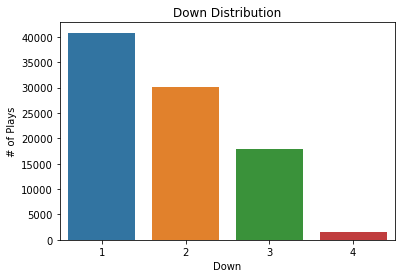

In [40]:
# plot downs
ax = sns.countplot(x = 'Down', data = plays)

# ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.title('Down Distribution')
plt.xlabel('Down')
plt.ylabel('# of Plays')
plt.savefig("Formation Dist")

See that number of plays goes down consistently with down...makes sense given a first down creates more opportunities for reset of number of downs before getting to 3rd and 4th down most times.

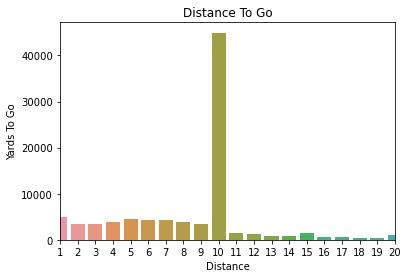

In [41]:
# plot downs
ax = sns.countplot(x = 'ToGo', data = plays)

plt.xlim(0, 19)
plt.title('Distance To Go')
plt.xlabel('Distance')
plt.ylabel('Yards To Go')
plt.savefig("Yards to Go Dist")

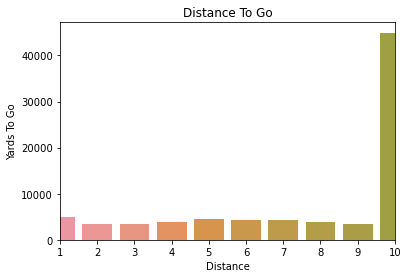

In [42]:
# plot downs
ax = sns.countplot(x = 'ToGo', data = plays)

plt.xlim(0, 9)
plt.title('Distance To Go')
plt.xlabel('Distance')
plt.ylabel('Yards To Go')
plt.savefig("Yards to Go Dist")

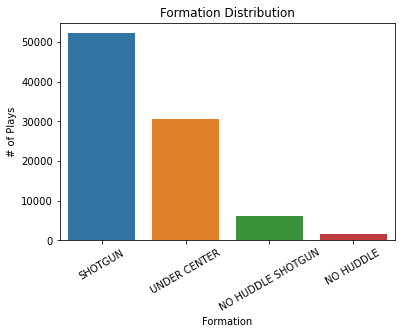

In [43]:
# plot formations
ax = sns.countplot(x = 'Formation', data = plays)

ax.set_xticklabels(ax.get_xticklabels(), rotation=30, ha='center')
plt.title('Formation Distribution')
plt.xlabel('Formation')
plt.ylabel('# of Plays')
plt.savefig("Formation Dist")

In [44]:
### This code shows number of distinct values inside each column

for column in plays:
    unique_vals = np.unique(plays[column])
    nr_values = len(unique_vals)
    if nr_values < 25:
        print('The number of values for feature {} :{} -- {}'
              .format(column, nr_values,unique_vals))
    else:
        print('The number of values for feature {} :{}'
              .format(column, nr_values))

The number of values for feature Quarter :5 -- [1 2 3 4 5]
The number of values for feature Minute :16 -- [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
The number of values for feature OffenseTeam :32
The number of values for feature Down :4 -- [1 2 3 4]
The number of values for feature ToGo :39
The number of values for feature YardLine :100
The number of values for feature Formation :4 -- ['NO HUDDLE' 'NO HUDDLE SHOTGUN' 'SHOTGUN' 'UNDER CENTER']
The number of values for feature IsRush :2 -- [0 1]
The number of values for feature IsTwoPointConversion :1 -- [0]


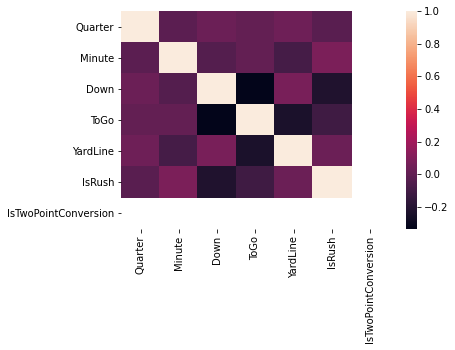

,Quarter,Minute,Down,ToGo,YardLine,IsRush,IsTwoPointConversion
Quarter,1.000000,-0.018561,0.032317,0.006611,0.044499,-0.023887,NaN
Minute,-0.018561,1.000000,-0.040777,0.006393,-0.091676,0.085719,NaN
Down,0.032317,-0.040777,1.000000,-0.332477,0.078228,-0.218806,NaN
ToGo,0.006611,0.006393,-0.332477,1.000000,-0.238745,-0.111218,NaN
YardLine,0.044499,-0.091676,0.078228,-0.238745,1.000000,0.036729,NaN
IsRush,-0.023887,0.085719,-0.218806,-0.111218,0.036729,1.000000,NaN
IsTwoPointConversion,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
### checking feature correlation
sns.heatmap(plays.corr())
plt.show()

plays.corr()

In [46]:
plays_feats = plays[['Quarter',
                  'Minute',
                  'Down', 
                  'ToGo', 
                  'YardLine',
                  'IsTwoPointConversion',
                  'IsRush',
                  'OffenseTeam']]

C:\Users\Nick\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)
C:\Users\Nick\anaconda3\lib\site-packages\seaborn\distributions.py:283: UserWarning: Data must have variance to compute a kernel density estimate.
  warnings.warn(msg, UserWarning)


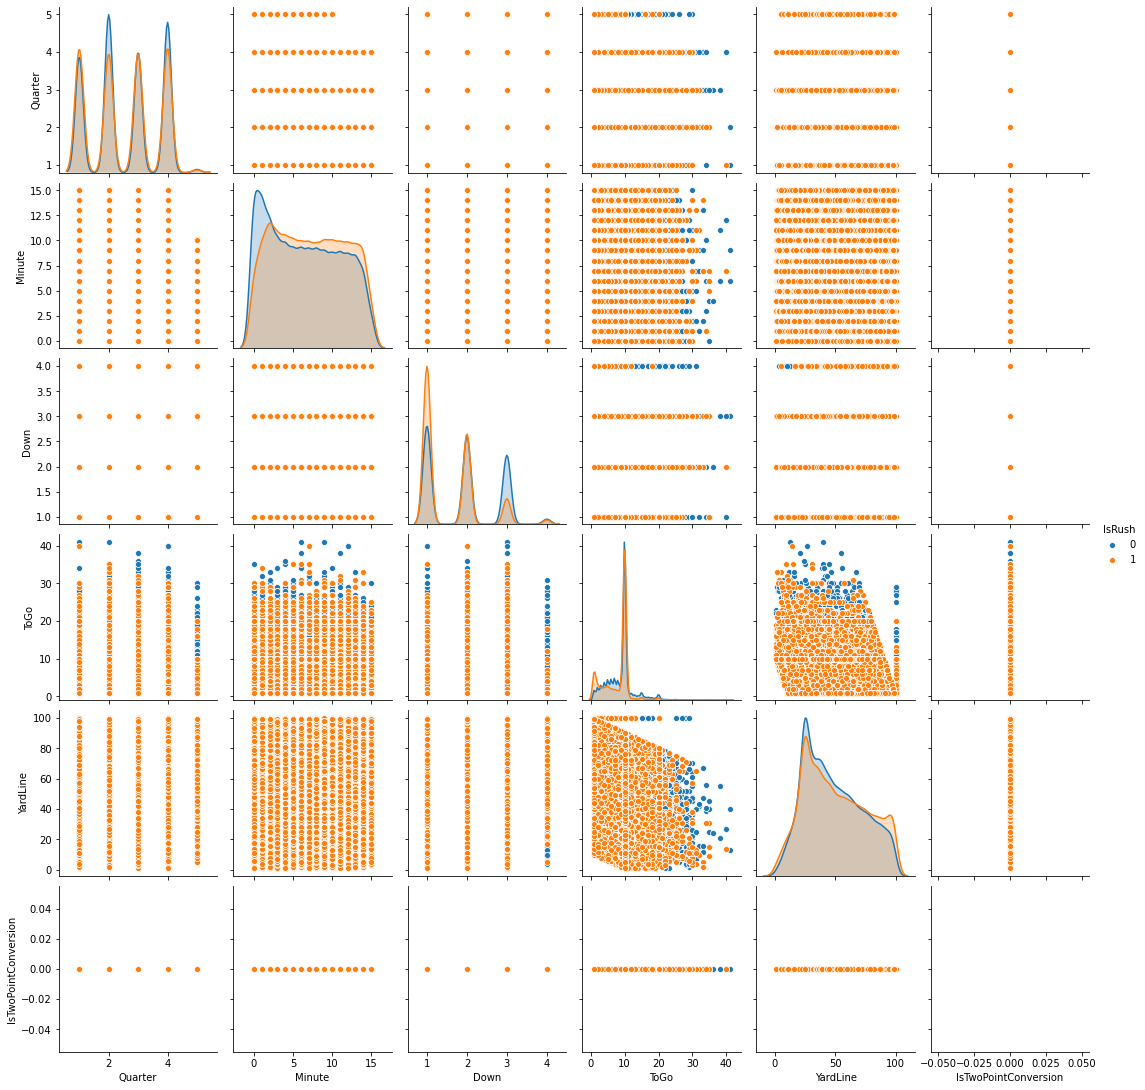

In [47]:
g = sns.pairplot(plays_feats, hue = 'IsRush')
plt.savefig('Feats PairPlot')

Observations:

    -As distance to go decreases, rushes seem to increase.  
    -4th down seems to be overwhelmingly a passing down (look to see if distance affects it)


Changes to make:
    
    -Need to make necessary changes for Quarter, Down, and Formation being categorical
    -Create down and distance bins?
    
    

# Model

### Train-Test-Split

In [48]:
### Splitting raw data ONLY ONCE

X = plays.drop(columns=['IsRush'], axis=1) # features
y = plays['IsRush']  # target vector
print(f'X shape:  {X.shape}')
print(f'y shape:  {y.shape}')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, stratify=y, random_state=12)

print(f'X_train shape:  {X_train.shape}')
print(f'y_train shape:  {y_train.shape}')

print(f'X_test shape:  {X_test.shape}')
print(f'y_test shape:  {y_test.shape}')

X shape:  (90523, 8)
y shape:  (90523,)
X_train shape:  (72418, 8)
y_train shape:  (72418,)
X_test shape:  (18105, 8)
y_test shape:  (18105,)


### One-Hot-Encode

In [49]:
ohe_division = X_train.iloc[:,:8]

In [50]:
X_train = ohe_division.apply(LabelEncoder().fit_transform)

In [51]:
ohe_division_test = X_test.iloc[:,:8]

In [52]:
X_test = ohe_division_test.apply(LabelEncoder().fit_transform)

## Baseline Model

#### Create decision tree

In [53]:
dec_tree = DecisionTreeClassifier(criterion='entropy', 
                                  max_depth=6, 
                                  random_state=1)
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot decision tree

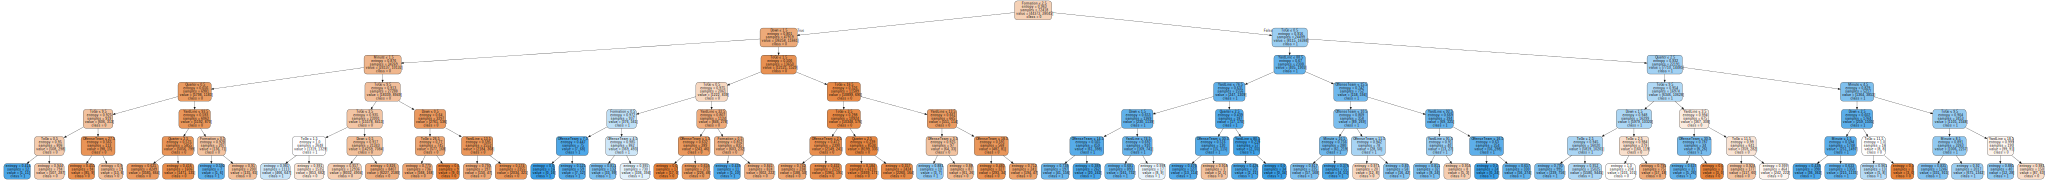

In [54]:
# Plot decision tree
dot_data = tree.export_graphviz(dec_tree, out_file=None,
                               feature_names=plays
                                .drop('IsRush', axis=1).columns,
                               class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Feature importance

In [55]:
### Calculating feature importance

for i, column in enumerate(X_train.columns):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature Quarter:, 0.027
Importance of feature Minute:, 0.048
Importance of feature OffenseTeam:, 0.007
Importance of feature Down:, 0.120
Importance of feature ToGo:, 0.173
Importance of feature YardLine:, 0.008
Importance of feature Formation:, 0.617
Importance of feature IsTwoPointConversion:, 0.000


#### Classification metric

In [56]:
# Print Confusion Matrix and Classification Report
print(confusion_matrix(y_test, dec_tree.predict(X_test)))
print(classification_report(y_test, dec_tree.predict(X_test)))

[[8965 2129]
 [2714 4297]]
              precision    recall  f1-score   support

           0       0.77      0.81      0.79     11094
           1       0.67      0.61      0.64      7011

    accuracy                           0.73     18105
   macro avg       0.72      0.71      0.71     18105
weighted avg       0.73      0.73      0.73     18105



#### Random forest/GridSearchCV

In [57]:
# Establish RandomForest Parameter
rf = RandomForestClassifier(random_state=101)

params = {
    'max_features': [1, 'sqrt', 'log2'],
    'max_depth': [None, 1, 2, 3, 4, 5],
    'criterion': ['entropy', 'gini']
}

grid = GridSearchCV(estimator= rf, param_grid=params, verbose=1)

In [58]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [59]:
grid.best_params_

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'log2'}

In [60]:
rf_best = grid.best_estimator_

#### Classification metric

In [61]:
print(confusion_matrix(y_test, rf_best.predict(X_test)))
print(classification_report(y_test, rf_best.predict(X_test)))

[[9017 2077]
 [2801 4210]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.79     11094
           1       0.67      0.60      0.63      7011

    accuracy                           0.73     18105
   macro avg       0.72      0.71      0.71     18105
weighted avg       0.73      0.73      0.73     18105



## Model 2

#### Dropping columns

In [62]:
### Drop columns according to Feature Importance
columns_to_drop = [
    'Quarter',
    'YardLine',
    'Minute',
    'OffenseTeam',
    'YardLine',
    'IsTwoPointConversion'
]

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Sanity Check
print(f'X_train shape:  {X_train.shape}')
print(f'y_train shape:  {y_train.shape}')

X_train shape:  (72418, 3)
y_train shape:  (72418,)


#### Create decision tree

In [63]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot decision tree

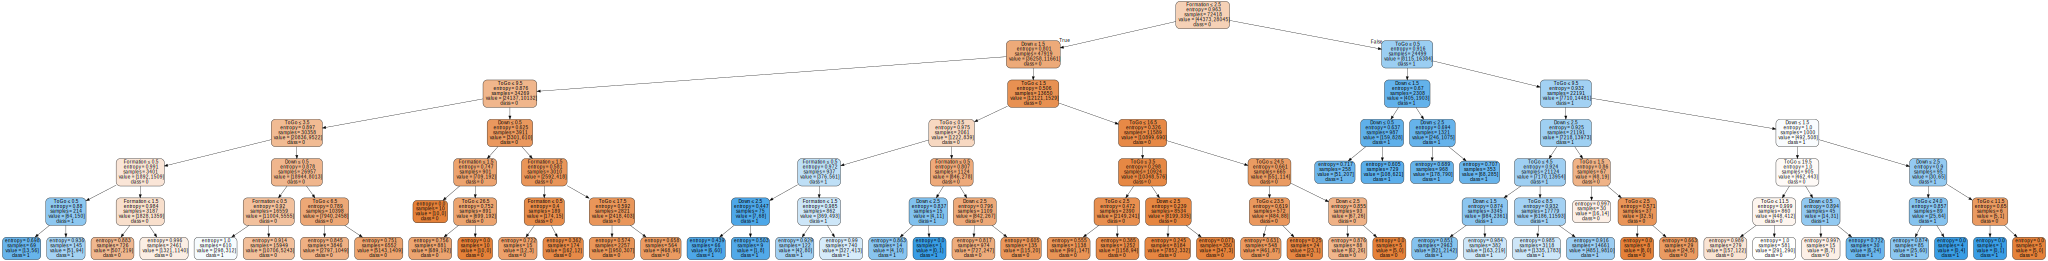

In [64]:
# Plot decision tree
dot_data = tree.export_graphviz(dec_tree, out_file=None,
                               feature_names=X_train.columns,
                               class_names=y_test.unique().astype(str),
                               filled=True, rounded=True,
                               special_characters=True)
graph = graphviz.Source(dot_data)
graph

#### Feature importance

In [65]:
### Calculating feature importance

for i, column in enumerate(X_train.columns):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature Down:, 0.132
Importance of feature ToGo:, 0.187
Importance of feature Formation:, 0.681


#### Classification metric

In [66]:
# Print Confusion Matrix and Classification Report
print(confusion_matrix(y_test, dec_tree.predict(X_test)))
print(classification_report(y_test, dec_tree.predict(X_test)))

[[8977 2117]
 [2768 4243]]
              precision    recall  f1-score   support

           0       0.76      0.81      0.79     11094
           1       0.67      0.61      0.63      7011

    accuracy                           0.73     18105
   macro avg       0.72      0.71      0.71     18105
weighted avg       0.73      0.73      0.73     18105



#### Random forest/GridSearchCV

In [67]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [68]:
rf_best = grid.best_estimator_

#### Classification metric

In [69]:
print(confusion_matrix(y_test, rf_best.predict(X_test)))
print(classification_report(y_test, rf_best.predict(X_test)))

[[9045 2049]
 [2814 4197]]
              precision    recall  f1-score   support

           0       0.76      0.82      0.79     11094
           1       0.67      0.60      0.63      7011

    accuracy                           0.73     18105
   macro avg       0.72      0.71      0.71     18105
weighted avg       0.73      0.73      0.73     18105



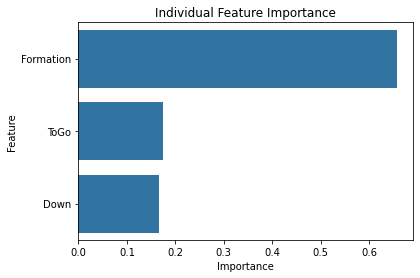

In [71]:
FI_df = pd.DataFrame(
    list(zip(X_train.columns, 
             rf_best.feature_importances_)),
    columns=['Feature', 'Importance']
)

FI_df.sort_values('Importance', inplace=True, ascending=False)


sns.barplot(x = 'Importance', y = 'Feature', data = FI_df, color = 'tab:blue').set_title('Individual Feature Importance')
plt.savefig('Final Feature Importance')

## Model 3

#### Dropping columns

In [72]:
### Drop formation column to see how down and distance do on their own.
columns_to_drop = ['Formation']

X_train = X_train.drop(columns=columns_to_drop)
X_test = X_test.drop(columns=columns_to_drop)

# Sanity Check
print(f'X_train shape:  {X_train.shape}')
print(f'y_train shape:  {y_train.shape}')

X_train shape:  (72418, 2)
y_train shape:  (72418,)


#### Create decision tree

In [73]:
dec_tree.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=1)

#### Plot decision tree

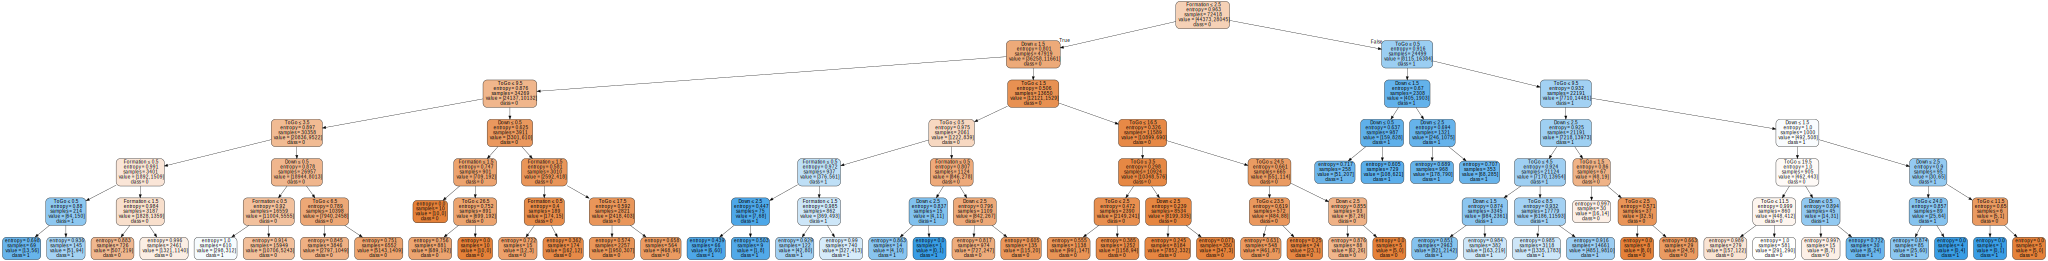

In [74]:
graph = graphviz.Source(dot_data)
graph

#### Feature importance

In [75]:
### Calculating feature importance

for i, column in enumerate(X_train.columns):
    print('Importance of feature {}:, {:.3f}'
          .format(column, dec_tree.feature_importances_[i]))
    
    fi = pd.DataFrame({'Variable': [column], 'Feature Importance Score': 
                       [dec_tree.feature_importances_[i]]})
    
    try:
        final_fi = pd.concat([final_fi, fi], ignore_index=True)
    except:
        final_fi = fi

Importance of feature Down:, 0.387
Importance of feature ToGo:, 0.613


#### Classification metric

In [76]:
# Print Confusion Matrix and Classification Report
print(confusion_matrix(y_test, dec_tree.predict(X_test)))
print(classification_report(y_test, dec_tree.predict(X_test)))

[[10165   929]
 [ 5383  1628]]
              precision    recall  f1-score   support

           0       0.65      0.92      0.76     11094
           1       0.64      0.23      0.34      7011

    accuracy                           0.65     18105
   macro avg       0.65      0.57      0.55     18105
weighted avg       0.65      0.65      0.60     18105



#### Random forest/GridSearchCV

In [77]:
grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(estimator=RandomForestClassifier(random_state=101),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [None, 1, 2, 3, 4, 5],
                         'max_features': [1, 'sqrt', 'log2']},
             verbose=1)

In [78]:
rf_best = grid.best_estimator_

#### Classification metric

In [79]:
print(confusion_matrix(y_test, rf_best.predict(X_test)))
print(classification_report(y_test, rf_best.predict(X_test)))

[[10161   933]
 [ 5378  1633]]
              precision    recall  f1-score   support

           0       0.65      0.92      0.76     11094
           1       0.64      0.23      0.34      7011

    accuracy                           0.65     18105
   macro avg       0.65      0.57      0.55     18105
weighted avg       0.65      0.65      0.60     18105



# Interpret

***Conclusion:***

- Formation, down, and distance to go are the 3 biggest factors when determining if a team is going to run or pass.  

- Certain situations for down and distance, given a certain formation, are much better indicators to if a team is going to run or pass than the team itself.  


***Recommendations:***

- Prepare your team based on SITUATIONS.  Situations are much more useful in predicting if a team is going to rush/pass on a given play than the actual team you're playing against.


- Be prepared for a pass on passing downs.


- On Offense, use more of a mixed games strategy.  Yes, first downs are important, but so is being unpredictable in your play calling. The average yards per rush on 3rd and medium+ (3 and 5+ to go) is 6.8, which is significantly higher than the 4.2 average yards per rush.  Especially useful in 4 Down territory where those extra yards can potentially mean the difference between a short punt or a potential field goal.



***Future work:***

** Incorporate current score going into the play into the model.  Depending on if a team is winning or losing later on in the game, they may elect to pass more often to save time, or rush more often to burn time.  This may provide valuable insight to plays depending on the quarter and help the model be more efficient.

** See if there is a strong relationship between the offensive coordinator and the types of plays they call. I.e- If an offensive coordinator changes teams, do they adapt to the new players, or do they usually implement the same system to new players.  (This is useful to know for teams that have a newly acquired Offensive Coordinator)

** Using team recorded data for games, have a more involved understanding of 'Formation' rather than shotgun and under center.  We can gain more insight for more specific situations based on the correct formation AND player personnel that is IN on the play.  (Ex: Tight ends who are viewed as more 'blocking' or 'receiving' players could potentially be useful indicators)

** Studying certain 'tells' in pre-play data can grant significant advantages to the teams that mask their plays the best.  


In [ ]:
###  Possibly categories for each down and distance.
### (1st and 10+, 1st and <10....2nd-4th down ALL 1-5,5-10,11+ INITIALLY...CHANGE IF NEEDED.)


# ### create function that categorizes the down and distance 
# ### of each play for a given df

# def down_and_distance(df):
#     """
#     """

### Bin data into areas of down AND distance: 
        ### (Yards/rush is slightly above 4, 
        ### so thats why it's seleted as pivotal point)
        
        ### 1st and 10, 1st and 11+, 1st and less than 10
        ### 2nd and 10+, 2nd and 7-9, 2nd and 4-6, 2nd and <= 3
        ### 3rd and 10+, 3rd and 7-9, 3rd and 4-6, 3rd and <= 3
        ### 4th and > 2, 4th and <=2
        


### DO THIS LATER IF I HAVE TIME  
### Create scores so that each play has one prior

### Create empty columns for scores, extra points, field goals, and safetys

# plays['Team_1_score'] = 0
# plays['Team_2_score'] = 0
# plays['TwoPointConversion'] = 0
# plays['Touchdown'] = 0
# plays['Extra_point'] = 0
# plays['Field_goal'] = 0
# plays['Safety'] = 0

# ### Each play needs to be run through a function that assigns values to
# ### Touchdown[6], Extra_point[1], Field_goal[3], Safety[2] columns
# ### After doing this, need to add all points from TD,EXTPT,FG,SFTY columns
# ### And continue to += for all remaining plays with same GameId

# ### Setting TD/FG/XP/SY values

# kc_vs_hou['Touchdown'][kc_vs_hou.IsTouchdown == 1] = 6
# kc_vs_hou['Extra_point'][kc_vs_hou.PlayType == 'EXTRA POINT'] = 1
# kc_vs_hou['Field_goal'][kc_vs_hou.PlayType == 'FIELD GOAL'] = 3
# kc_vs_hou['TwoPointConversion'][kc_vs_hou.IsTwoPointConversionSuccessful == 1] = 2


# Pseudo...

###  ALWAYS OFFENSE
###  IsTwoPointConversion (If = 1, means 2 pts for OFF TEAM)
###  Extra_point (If = 1, means 2 pts for OFF TEAM)
###  Field_goal (If = 1, means 2 pts for OFF TEAM)


### ALWAYS DEFENSE
### Safety (If = 1, means 2 pts for DEF TEAM)-----(Need to look through description for Safety??)


###  Touchdown  (If = 1, means 6pts)
#  If IsInterception = 1, 6pts for DEF TEAM
#  If IsFumble = 1, 6pts for DEF TEAM
#  (If IsInterception = 0 & IsFumble = 0), 6pts for OFF TEAM


### Need to create function that iterates through entire df
### Create 'binary' columns for Touchdown, Field_goal, Extra_point, Safety, TwoPointConversion
### THEN use formula to add all columns given matching GAME ID & OFF TEAM from PREVIOUS PLAYS

# Forumla
# Team_1_score = (6*(sum(Touchdown))) + (2*(sum(TwoPointConversion))) + sum(Extra_point) + (3*sum(Field_goal))
# Team_2_score = (6*(sum(Touchdown))) + (2*(sum(TwoPointConversion))) + sum(Extra_point) + (3*sum(Field_goal))

# NEED TO ONLY ADD BINARY VALUE TO TEAM WHO SCORES COLUMN


### need to define a function that uses a for loop to iterate through df to 
### add scores to have score column for each play, also resetting scores 
### when exposed to new GameId's

# Reset scores if new game
# LEARN HOW TO ITERATE THROUGH NEW/OLD ROW VALUE

# generate empty list to fill GameId's as we use them
# game_ids = []

# if Game_Id ISNT IN list of game_ids
#     game_ids.append(Game_Id)
#     Team_1_score = 0
#     Team_2_score = 0

# if GameId = old_value:
#     continue

# # kickoff and punt return TD scenarios
# if (df['PlayType'] == 'KICK OFF' or 'PUNT') & df['IsTouchdown'] = 1:
#     Team_2_score += 6

# # interception and fumble return TD scenarios
# if (df['IsInterception'] = 1 or df['IsFumble'] = 1) & df['IsTouchdown'] = 1:
#     Team_2_score += 6

# # offensive TD scenarios
# if (df['IsTouchdown'] = 1) & (df['IsInterception'] = 1 & df['IsFumble'] = 1):
#     Team_1_score 


### need to see where game Id has been before and call previous score and if 
### its a new game (NaN for Offense and Defense teams) set scores equal to 0.

### Assign score to team based on offense/defense

# def set_score(df):
#     """
#     """  
        
#     if plays['IsTouchdown'] == 1 & plays['IsInterception'] == 0 & plays['IsFumble'] == 0:
#         return(plays['Offense_score'] += 6)

    
#     ### use TD/extra_point/field_goal,safety columns to identify scores



### Creating categories for down and distance

# plays_copy = plays.copy()

# plays_copy['1st_10_plus'] = 0
# plays_copy['1st_less_than_10'] = 0
# plays_copy['2nd_10_plus'] = 0
# plays_copy['2nd_btw_4_and_10'] = 0
# plays_copy['2nd_3_less'] = 0
# plays_copy['3rd_10_plus'] = 0
# plays_copy['3rd_btw_4_10'] = 0
# plays_copy['3rd_3_less'] = 0
# plays_copy['4th_3_plus'] = 0
# plays_copy['4th_less_than_2'] = 0